### Import libraries

In [1]:
import pandas as pd
import numpy as np
import missingno as msno

# Pandas warning messages (optional)
pd.options.mode.chained_assignment = None  #default='warn'

# Plot options
import matplotlib.pyplot as plt
import seaborn as sns
sns.palplot(sns.color_palette('deep'))
sns.set_style("whitegrid")
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Load data
#### The dataset was downloaded from [insideairbnb](http://insideairbnb.com/get-the-data.html) for the city of Austin, Date Compiled on March 17th, 2020. 
#### Let's import the dataset and take a look at the first few observations.

In [2]:
# Importing dataset and checking the top 5 data points
df = pd.read_csv('data/listings.csv', low_memory=False, index_col='id')
df.head()

listing_url       scrape_id last_scraped  \
id                                                                     
2265  https://www.airbnb.com/rooms/2265  20200317143754   2020-03-17   
5245  https://www.airbnb.com/rooms/5245  20200317143754   2020-03-17   
5456  https://www.airbnb.com/rooms/5456  20200317143754   2020-03-17   
5769  https://www.airbnb.com/rooms/5769  20200317143754   2020-03-17   
6413  https://www.airbnb.com/rooms/6413  20200317143754   2020-03-17   

                                                   name  \
id                                                        
2265   Zen-East in the Heart of Austin (monthly rental)   
5245  Eco friendly, Colorful, Clean, Cozy monthly share   
5456          Walk to 6th, Rainey St and Convention Ctr   
5769                                     NW Austin Room   
6413                      Gem of a Studio near Downtown   

                                                summary  \
id                                                        
2265  Zen East is situated in a vibrant & diverse mu...   
5245  Situated in a vibrant & diverse multicultural ...   
5456  Great central  location for walking to Convent...   
5769                                                NaN   
6413  Great studio apartment, perfect for couples or...   

                                                  space  \
id                                                        
2265  This colorful and clean 1923 house was complet...   
5245  This green, colorful, clean and cozy house was...   
5456  Cute Private Studio apartment located in Willo...   
5769  Looking for a comfortable inexpensive room to ...   
6413  !!!!! SXSW info !!!!! Presently open (again!) ...   

                                            description experiences_offered  \
id                                                                            
2265  Zen East is situated in a vibrant & diverse mu...                none   
5245  Situated in a vibrant & diverse multicultural ...                none   
5456  Great central  location for walking to Convent...                none   
5769  Looking for a comfortable inexpensive room to ...                none   
6413  Great studio apartment, perfect for couples or...                none   

                                  neighborhood_overview  \
id                                                        
2265                                                NaN   
5245                                                NaN   
5456  My neighborhood is ideally located if you want...   
5769  Quiet neighborhood with lots of trees and good...   
6413  Travis Heights is one of the oldest neighborho...   

                                                  notes  \
id                                                        
2265  A 2013 Genuine Buddy Scooter 125 may be availa...   
5245  Please note: A two story studio was built in t...   
5456  Parking on street requires a permit.  Permits ...   
5769                                                NaN   
6413  Our calendar only extends a few months. If you...   

                                                transit  \
id                                                        
2265  5 min walk to Capitol Metro Rail (train that t...   
5245                                                NaN   
5456  Bus stop around the block.  Uber, Lyft, Ride, ...   
5769  We are approximately 16 miles from downtown Au...   
6413  Parking for our place is on the street, roughl...   

                                                 access  \
id                                                        
2265  Several local restaurants, small clubs, music ...   
5245                                                NaN   
5456              Guests have access to yard and patio.   
5769                             Gravel Parking Kitchen   
6413     Private patio with lounge chairs and umbrella.   

                                            interaction  \
id          

In [3]:
# Now lets check the shape of the df
df.shape

(11668, 105)

The Airbnb dataset for Austin, TX consists of 106 features (including id) and 11668 observations. We need to look at these features closely and drop the ones that do not help our model to predict the rental prices. 

In [4]:
# Specifying max_cols=df.shape[1] so we can look at all the columns in df.info()
df.info(max_cols=df.shape[1])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11668 entries, 2265 to 42931550
Data columns (total 105 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   listing_url                                   11668 non-null  object 
 1   scrape_id                                     11668 non-null  int64  
 2   last_scraped                                  11668 non-null  object 
 3   name                                          11668 non-null  object 
 4   summary                                       11244 non-null  object 
 5   space                                         9083 non-null   object 
 6   description                                   11461 non-null  object 
 7   experiences_offered                           11668 non-null  object 
 8   neighborhood_overview                         7937 non-null   object 
 9   notes                                         5553 non

In [5]:
# Sorting null columns based on the number of null values in each column
print('Columns with Null values by their count:')
df.isnull().sum().sort_values(ascending=False)[:25]

Columns with Null values by their count:


neighbourhood_group_cleansed    11668
medium_url                      11668
xl_picture_url                  11668
thumbnail_url                   11668
license                         11621
square_feet                     11476
monthly_price                   10931
weekly_price                    10793
notes                            6115
access                           4917
transit                          4370
host_about                       4099
interaction                      3862
house_rules                      3759
neighborhood_overview            3731
host_response_time               3462
host_response_rate               3462
security_deposit                 3100
host_acceptance_rate             2765
review_scores_location           2675
review_scores_value              2674
review_scores_checkin            2670
review_scores_communication      2670
review_scores_accuracy           2669
review_scores_cleanliness        2669
dtype: int64

In [6]:
#sns.pairplot(df)

Using MSNO to look at Misisng Values in 25 columns visually.

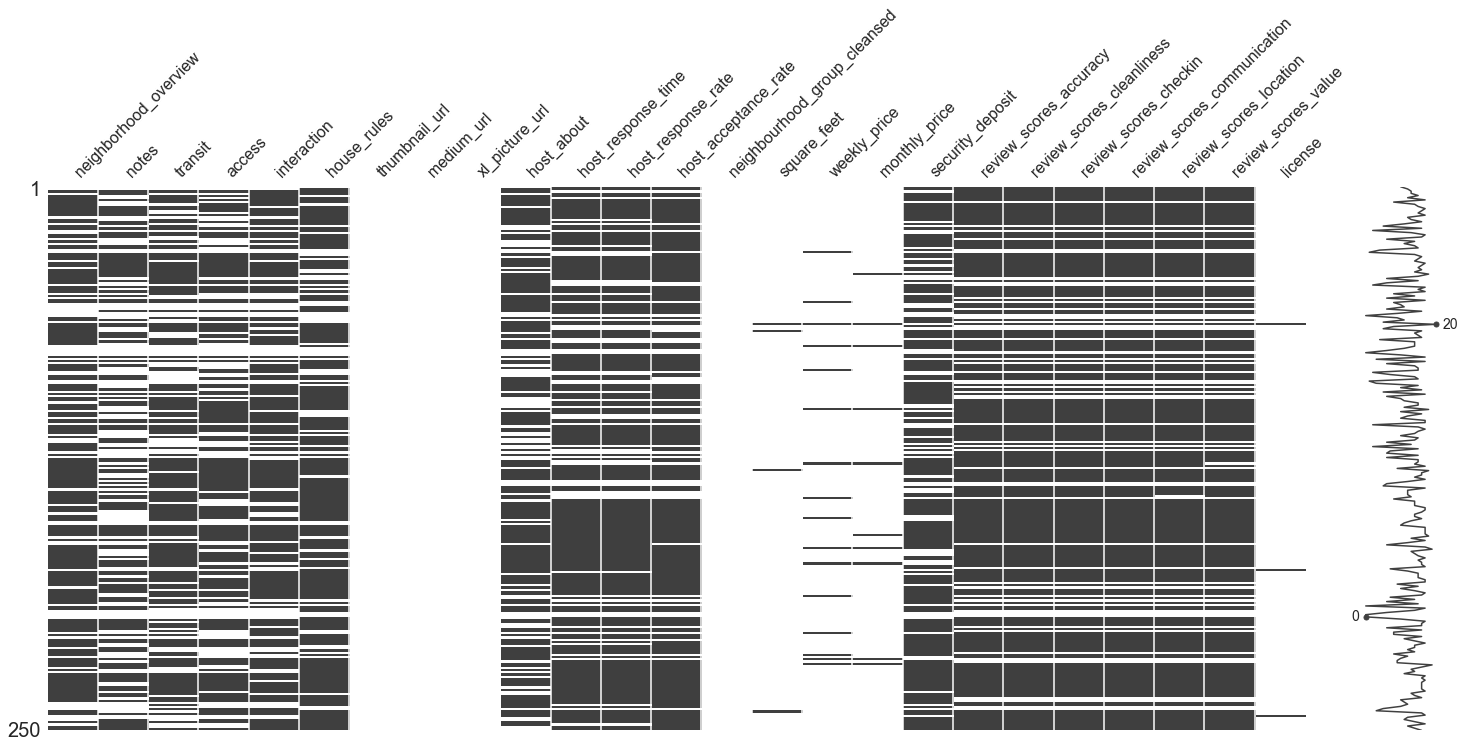

In [7]:
filtered_data = msno.nullity_filter(df, filter='bottom', n=25, p=0.999) # or filter='top'
msno.matrix(filtered_data.sample(250))

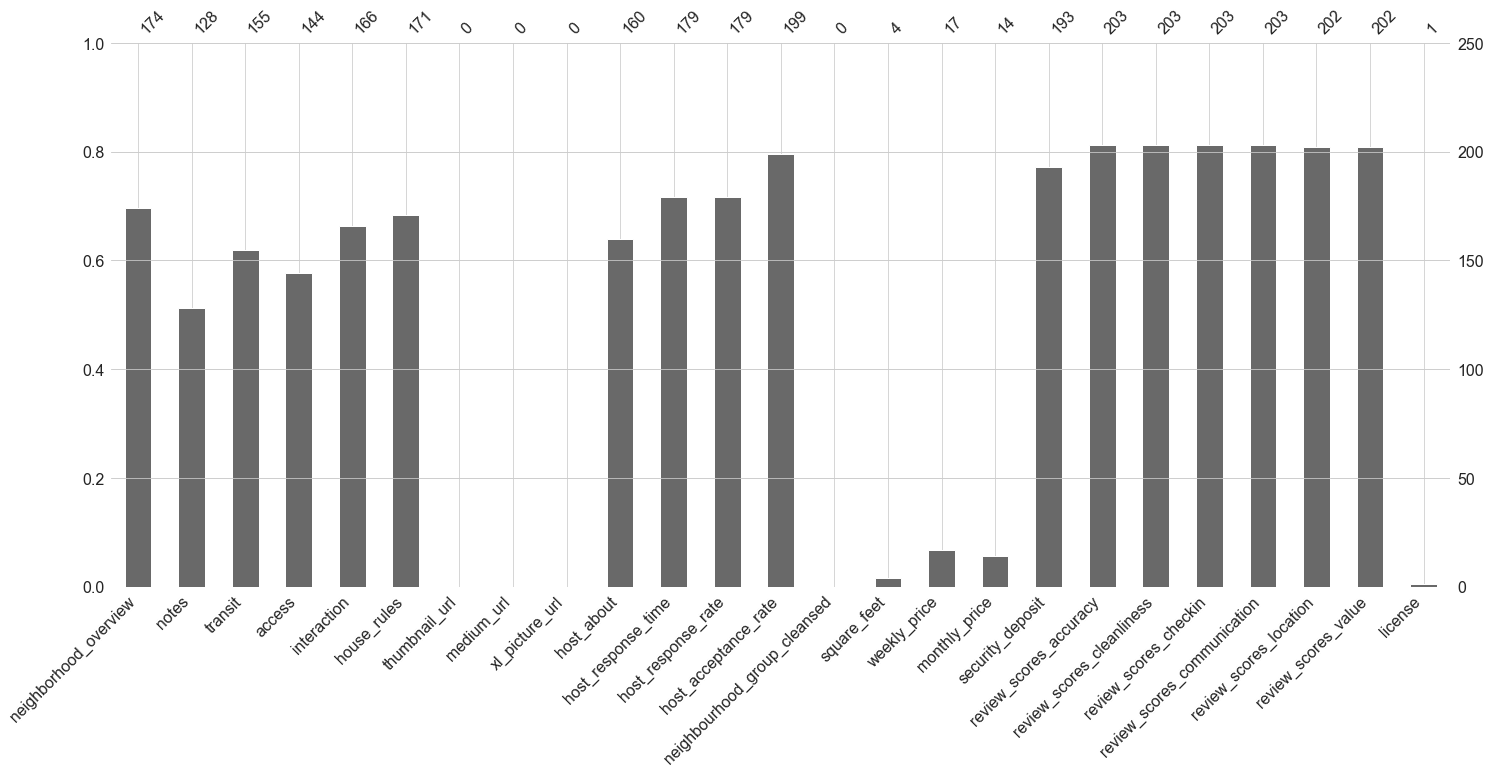

In [8]:
msno.bar(filtered_data.sample(250))

Features like 'square_feet', 'monthly_price' or 'weekly_price' have a lot of NULL values but we can use bedroom, bathroom, and accommodates data as a replacement for space size and also use 'price' for our prediction instead of 'monthly_price' or 'weekly_price'. 

#### Price (1):

In [11]:
# Comparing 'price' with 'monthly_price' and 'weekly_price' to see which ones we need to keep
df[['price','monthly_price', 'weekly_price']].head()

price monthly_price weekly_price
id                                      
2265  $225.00           NaN          NaN
5245  $100.00           NaN          NaN
5456   $95.00           NaN          NaN
5769   $40.00           NaN      $160.00
6413   $99.00     $1,900.00      $700.00

In [10]:
# Looking at describe() to get some insights on 'price' and other numerical values
df.describe()

scrape_id  thumbnail_url  medium_url  xl_picture_url       host_id  \
count  1.166800e+04            0.0         0.0             0.0  1.166800e+04   
mean   2.020032e+13            NaN         NaN             NaN  7.673078e+07   
std    2.511826e+00            NaN         NaN             NaN  8.628560e+07   
min    2.020032e+13            NaN         NaN             NaN  2.300000e+01   
25%    2.020032e+13            NaN         NaN             NaN  8.761906e+06   
50%    2.020032e+13            NaN         NaN             NaN  3.939813e+07   
75%    2.020032e+13            NaN         NaN             NaN  1.185659e+08   
max    2.020032e+13            NaN         NaN             NaN  3.416244e+08   

       host_listings_count  host_total_listings_count  neighbourhood_cleansed  \
count         11666.000000               11666.000000            11668.000000   
mean             66.963398                  66.963398            78722.143469   
std             281.215856                 281.215856               20.689544   
min               0.000000                   0.000000            78701.000000   
25%               1.000000                   1.000000            78704.000000   
50%               1.000000                   1.000000            78717.000000   
75%               4.000000                   4.000000            78744.000000   
max            2016.000000                2016.000000            78759.000000   

       neighbourhood_group_cleansed       zipcode      latitude     longitude  \
count                           0.0  11580.000000  11668.000000  11668.000000   
mean                            NaN  78721.910535     30.278100    -97.751143   
std                             NaN     20.859859      0.057423      0.056388   
min                             NaN  78617.000000     30.118850    -98.053550   
25%                             NaN  78703.000000     30.244320    -97.767315   
50%                             NaN  78705.000000     30.266820    -97.744810   
75%                             NaN  78744.000000     30.298533    -97.721360   
max                             NaN  78767.000000     30.512280    -97.560620   

       accommodates     bathrooms      bedrooms          beds  square_feet  \
count  11668.000000  11655.000000  11653.000000  11601.000000   192.000000   
mean       4.708348      1.543930      1.786407      2.544005  1209.765625   
std        3.252291      0.873916      1.273369      2.726590   818.642672   
min        1.000000      0.000000      0.000000      0.000000     0.000000   
25%        2.000000      1.000000      1.000000      1.000000   600.000000   
50%        4.000000      1.000000      1.000000      2.000000  1125.000000   
75%        6.000000      2.000000      2.000000      3.000000  1600.000000   
max       33.000000     17.000000     23.000000    132.000000  4200.000000   

       guests_included  minimum_nights  maximum_nights  \
count     11668.000000    11668.000000    11668.000000   
mean          2.427580        5.282911      624.495972   
std           2.743511       16.622890      528.773959   
min           1.000000        1.000000        1.000000   
25%           1.000000        1.000000       29.000000   
50%           1.000000        2.000000     1125.000000   
75%           2.000000        2.000000     1125.000000   
max          36.000000      500.000000     1825.000000   

       minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  \
count            11668.000000            11668.000000            11668.000000   
mean                 4.740744                5.858330              704.373672   
std                 15.609035               16.525128              517.836372   
min                  1.000000                1.000000                1.000000   
25%                  1.000000                1.000000               30.000000   
50%                  2.000000                2.000000             1125.000000   
75%                  2.000000       

Notice that 'price' is not included on the describe() above! Let's investigate why 'price' did not show up!

In [12]:
# Lets look at the top values in 'price' as well as finding out the data type
df['price'].head()

id
2265    $225.00
5245    $100.00
5456     $95.00
5769     $40.00
6413     $99.00
Name: price, dtype: object

'price' is type object and needs to be transformed to the correct data type.

In [13]:
# Convert 'price' from string currency to float
df['price'] = df['price'].str.replace('$', '').str.replace(',', '').astype(float, 2)

In [14]:
# Verify 'price' type is float
df['price'].head()

id
2265    225.0
5245    100.0
5456     95.0
5769     40.0
6413     99.0
Name: price, dtype: float64

In [15]:
# Looking at describe() to get some insights on 'price'
df.price.describe()

count    11668.000000
mean       484.237830
std       1480.352627
min          0.000000
25%         80.000000
50%        149.000000
75%        300.000000
max      14298.000000
Name: price, dtype: float64

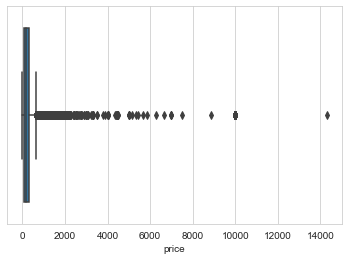

In [16]:
# Visualizing the 'price' column using boxplot
sns.boxplot(df['price'])

In [22]:
#from scipy.stats import zscore
#df['price'].apply(zscore)

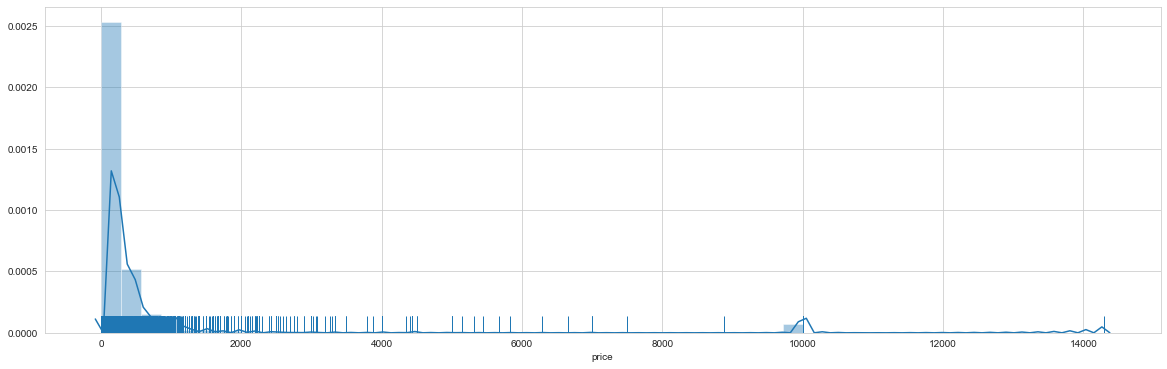

In [23]:
plt.figure(figsize=(20,6))
sns.distplot(df['price'], rug=True)

In [24]:
df['price'].isnull().sum()

0

In [25]:
df[df['price']==0][['bedrooms', 'bathrooms', 'price', 'accommodates', 'zipcode', 'listing_url']]

bedrooms  bathrooms  price  accommodates  zipcode  \
id                                                            
20269052       1.0        1.0    0.0             3  78701.0   
20541331       1.0        1.0    0.0             2  78704.0   
21378172       4.0        2.0    0.0            10  78704.0   

                                    listing_url  
id                                               
20269052  https://www.airbnb.com/rooms/20269052  
20541331  https://www.airbnb.com/rooms/20541331  
21378172  https://www.airbnb.com/rooms/21378172

In [38]:
#df.groupby(df['accommodates'])['price'].median()

In [33]:
df['price'].replace(0.0, np.nan, inplace=True)
df['price'].fillna(df.groupby(df['accommodates'])['price'].transform('median'), inplace=True)

In [34]:
print(df.loc[21378172]['price'])
print(df.loc[20541331]['price'])
print(df.loc[20269052]['price'])

450.0
80.0
100.0


In [40]:
# We checked the listing_url and below prices are the actual prices which are close to the median
#df.at[21378172, 'price'] = 435
#df.at[20541331, 'price'] = 130
#df.at[20269052, 'price'] = 104

In [41]:
# All these rentals for $1 /night are for Hurrican Harvey Refugees and haven't been updated since 2017 so we can drop them.
df[df['price']==1][['bedrooms', 'bathrooms', 'price', 'listing_url']]

bedrooms  bathrooms  price                            listing_url
id                                                                         
20654658       0.0        0.0    1.0  https://www.airbnb.com/rooms/20654658
20674436       2.0        1.0    1.0  https://www.airbnb.com/rooms/20674436
20708014       1.0        1.5    1.0  https://www.airbnb.com/rooms/20708014
20780987       1.0        1.0    1.0  https://www.airbnb.com/rooms/20780987

In [42]:
df= df[df['price'] !=1.0]

In [47]:
df[df['price']==1][['bedrooms', 'bathrooms', 'price', 'listing_url']]

Empty DataFrame
Columns: [bedrooms, bathrooms, price, listing_url]
Index: []

In [48]:
df[df['price']==5][['bedrooms', 'bathrooms', 'price', 'listing_url']]

bedrooms  bathrooms  price                            listing_url
id                                                                         
19840835       0.0        1.0    5.0  https://www.airbnb.com/rooms/19840835

In [49]:
df= df[df['price'] !=5.0]

In [50]:
df[df['price']==10][['bedrooms', 'bathrooms', 'price', 'listing_url']]

bedrooms  bathrooms  price                            listing_url
id                                                                         
10451030       1.0        1.0   10.0  https://www.airbnb.com/rooms/10451030
20647325       1.0        1.0   10.0  https://www.airbnb.com/rooms/20647325
20691399       1.0        1.0   10.0  https://www.airbnb.com/rooms/20691399
20713150       1.0        1.0   10.0  https://www.airbnb.com/rooms/20713150
21946737       1.0        1.0   10.0  https://www.airbnb.com/rooms/21946737
24208274       1.0        1.0   10.0  https://www.airbnb.com/rooms/24208274
32766208       5.0        5.5   10.0  https://www.airbnb.com/rooms/32766208
35315186       0.0        1.0   10.0  https://www.airbnb.com/rooms/35315186
36770125       0.0        1.0   10.0  https://www.airbnb.com/rooms/36770125

In [51]:
df= df[df['price'] !=10.0]

In [52]:
df[df['price']==14][['bedrooms', 'bathrooms', 'price', 'listing_url']]
# All of these listings are for camp sites and can be marked as NaN and dropped later at the end

bedrooms  bathrooms  price                            listing_url
id                                                                         
372254         1.0        1.0   14.0    https://www.airbnb.com/rooms/372254
685447         1.0        1.0   14.0    https://www.airbnb.com/rooms/685447
685448         1.0        1.0   14.0    https://www.airbnb.com/rooms/685448
685451         0.0        1.0   14.0    https://www.airbnb.com/rooms/685451
936496         1.0        1.0   14.0    https://www.airbnb.com/rooms/936496
945803         0.0        1.0   14.0    https://www.airbnb.com/rooms/945803
968760        10.0        1.5   14.0    https://www.airbnb.com/rooms/968760
968817        10.0        1.0   14.0    https://www.airbnb.com/rooms/968817
12165731       1.0        1.0   14.0  https://www.airbnb.com/rooms/12165731
30123710       0.0        1.0   14.0  https://www.airbnb.com/rooms/30123710

In [53]:
df= df[df['price'] !=14.0]

In [54]:
df[df['price']==15][['bedrooms', 'bathrooms', 'price', 'listing_url']]
# These are also camp sites listings and can be dropped

bedrooms  bathrooms  price                            listing_url
id                                                                         
15217595       0.0        0.0   15.0  https://www.airbnb.com/rooms/15217595
18849155       1.0        1.0   15.0  https://www.airbnb.com/rooms/18849155
39676879       0.0        1.0   15.0  https://www.airbnb.com/rooms/39676879

In [55]:
df= df[df['price'] !=15.0]

In [57]:
df[df['price'] ==15]

Empty DataFrame
Columns: [listing_url, scrape_id, last_scraped, name, summary, space, description, experiences_offered, neighborhood_overview, notes, transit, access, interaction, house_rules, thumbnail_url, medium_url, picture_url, xl_picture_url, host_id, host_url, host_name, host_since, host_location, host_about, host_response_time, host_response_rate, host_acceptance_rate, host_is_superhost, host_thumbnail_url, host_picture_url, host_neighbourhood, host_listings_count, host_total_listings_count, host_verifications, host_has_profile_pic, host_identity_verified, street, neighbourhood, neighbourhood_cleansed, neighbourhood_group_cleansed, city, state, zipcode, market, smart_location, country_code, country, latitude, longitude, is_location_exact, property_type, room_type, accommodates, bathrooms, bedrooms, beds, bed_type, amenities, square_feet, price, weekly_price, monthly_price, security_deposit, cleaning_fee, guests_included, extra_people, minimum_nights, maximum_nights, minimum_minimum_nights, maximum_minimum_nights, minimum_maximum_nights, maximum_maximum_nights, minimum_nights_avg_ntm, maximum_nights_avg_ntm, calendar_updated, has_availability, availability_30, availability_60, availability_90, availability_365, calendar_last_scraped, number_of_reviews, number_of_reviews_ltm, first_review, last_review, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value, requires_license, license, jurisdiction_names, instant_bookable, is_business_travel_ready, cancellation_policy, require_guest_profile_picture, require_guest_phone_verification, ...]
Index: []

In [56]:
df[df['price']==16][['bedrooms', 'bathrooms', 'price', 'listing_url']]
# chekced url's randomly and these listings are reliable

bedrooms  bathrooms  price                            listing_url
id                                                                         
12336677       1.0        1.0   16.0  https://www.airbnb.com/rooms/12336677
14221592       1.0        2.0   16.0  https://www.airbnb.com/rooms/14221592
14463342       1.0        2.0   16.0  https://www.airbnb.com/rooms/14463342
14483719       1.0        2.0   16.0  https://www.airbnb.com/rooms/14483719
15034794       1.0        2.0   16.0  https://www.airbnb.com/rooms/15034794
16649075       1.0        1.0   16.0  https://www.airbnb.com/rooms/16649075
18787194       1.0        1.0   16.0  https://www.airbnb.com/rooms/18787194
18807173       1.0        1.0   16.0  https://www.airbnb.com/rooms/18807173
20439382       1.0        1.0   16.0  https://www.airbnb.com/rooms/20439382
20771704       1.0        1.0   16.0  https://www.airbnb.com/rooms/20771704
21307845       1.0        1.0   16.0  https://www.airbnb.com/rooms/21307845
21881708       1.0        1.0   16.0  https://www.airbnb.com/rooms/21881708
21881807       1.0        1.0   16.0  https://www.airbnb.com/rooms/21881807
21881859       1.0        1.0   16.0  https://www.airbnb.com/rooms/21881859
21881893       1.0        1.0   16.0  https://www.airbnb.com/rooms/21881893
27021568       1.0        1.0   16.0  https://www.airbnb.com/rooms/27021568
27548039       1.0        3.0   16.0  https://www.airbnb.com/rooms/27548039
27579562       1.0        3.0   16.0  https://www.airbnb.com/rooms/27579562
27902782       1.0        1.0   16.0  https://www.airbnb.com/rooms/27902782
27903125       1.0        1.0   16.0  https://www.airbnb.com/rooms/27903125
33452080       1.0        1.0   16.0  https://www.airbnb.com/rooms/33452080
37291791       1.0        3.0   16.0  https://www.airbnb.com/rooms/37291791
37292336       1.0        3.0   16.0  https://www.airbnb.com/rooms/37292336
37449553       1.0        1.0   16.0  https://www.airbnb.com/rooms/37449553
37449692       1.0        1.0   16.0  https://www.airbnb.com/rooms/37449692

In [58]:
#df.drop(df.index[[19840835, 10451030, 20647325, 20691399, 20713150, 21946737, 24208274, 32766208, 35315186, 36770125,
#                 372254, 685447, 685448, 685451, 936496, 945803, 968760, 968817, 12165731, 30123710,
#                 15217595, 18849155, 39676879]], axis=1, inplace=True)

In [59]:
df[df['price']<= 20]['property_type'].value_counts()

Apartment    37
House        10
Tipi          2
Bungalow      1
Camper/RV     1
Cottage       1
Townhouse     1
Other         1
Name: property_type, dtype: int64

In [60]:
df.price.describe()

count    11641.000000
mean       485.390688
std       1481.881108
min         16.000000
25%         80.000000
50%        149.000000
75%        300.000000
max      14298.000000
Name: price, dtype: float64

Defined a mask for price based on below 25% quartile as 'low', below 50% as 'med' and the rest was set as 'high'

In [61]:
'''
price_bins=[]
for price in df.price:
    if price < 81:
        price_bins.append('low')
    if price < 150:
        price_bins.append('med')
    else:
        price_bins.append('high')
'''

"\nprice_bins=[]\nfor price in df.price:\n    if price < 81:\n        price_bins.append('low')\n    if price < 150:\n        price_bins.append('med')\n    else:\n        price_bins.append('high')\n"

In [62]:
#price_bins = pd.cut(df['price'], bins=10)
#price_bins.value_counts().hist()

In [63]:
#[[x,price_bins.count(x)] for x in set(price_bins)]

In [64]:
#df['price_bins'] = pd.Series(price_bins)

In [65]:
#df[['price', 'price_bins']]

In [66]:
#print(df['price_bins'].value_counts())
#df['price_bins'].value_counts().plot(kind='bar');

In [67]:
'''
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
sns.scatterplot(data=df, x='longitude', y='latitude', hue='price_bins', palette='Dark2', ax=ax);
'''

"\nsns.set_style('ticks')\nfig, ax = plt.subplots()\nfig.set_size_inches(11, 8)\nsns.scatterplot(data=df, x='longitude', y='latitude', hue='price_bins', palette='Dark2', ax=ax);\n"

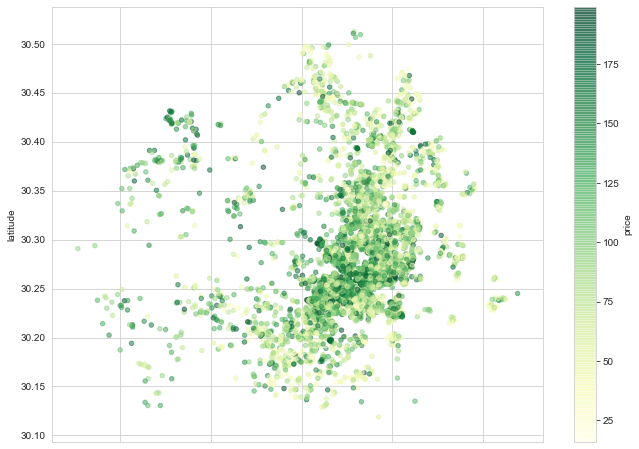

In [68]:
# Using 'longitude' and 'latitude' to plot and look at the areas where the 'price' is below 200
df[df['price']<200].plot.scatter(x='longitude', y='latitude', c='price', figsize=(11,8), cmap='YlGn', alpha=0.5);

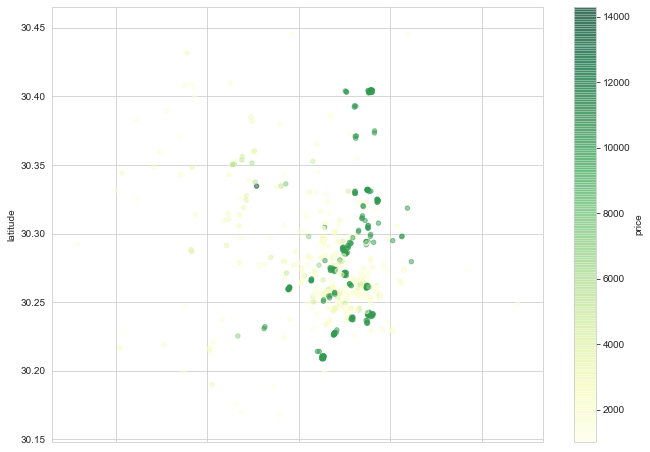

In [69]:
# Using 'longitude' and 'latitude' to plot and look at the areas where the 'price' is above 1000
df[df['price']>1000].plot.scatter(x='longitude', y='latitude', c='price', figsize=(11,8), cmap='YlGn', alpha=0.5);

In [70]:
import plotly.express as px
fig = px.scatter(df, x="longitude", y="latitude", color='price', hover_data=['property_type'])
fig.show()

#### Property Type:

In [ ]:
# Let's look at the property_type distribution
print(df['property_type'].value_counts(normalize=True))
df['property_type'].value_counts().plot(kind='bar');

In [ ]:
property_outliers = df[df['price'] >= 8000]['property_type'].value_counts(normalize=True)
print(property_outliers)
property_outliers.plot(kind='bar');

In [ ]:
df.groupby(df['property_type']== 'Apartment')['price'].median()

In [ ]:
apartment = df[df['property_type']== 'Apartment'][['bedrooms', 'bathrooms', 'accommodates', 'price', 'listing_url']]
apartment[apartment['price'] >=8000].sort_values('accommodates', ascending=False)
# I checked some of these listings randomly and only 1 of them has the price of $8,000/night. I will replace the price
# with the median price associated to the accommodates rate

In [ ]:
df[df['property_type']== 'Apartment']['price'].median()

In [ ]:
villa = df[df['property_type'] == 'Villa']['price'].sort_values(ascending=False)
print(villa)
villa[:10].plot(y='price', kind='bar', fig=(20,8))

In [ ]:
df[df['property_type'] == 'Villa'][['price', 'listing_url']].sort_values('price', ascending=False)

In [ ]:
df.at[36868625, 'price'] = 9630

In [ ]:
df[df['property_type'] == 'Villa'][['price', 'listing_url']].sort_values('price', ascending=False)

In [ ]:
df[df['property_type'] == 'Villa']['price'].median()

In [ ]:
df[df['property_type'] == 'House']['price'].value_counts().sort_index(ascending=False)

In [ ]:
df[df['property_type'] == 'House']['price'].median()

In [ ]:
#pd.options.display.max_rows = 60

In [ ]:
df.groupby(['property_type', 'zipcode'])['price'].median()

In [ ]:
df.zipcode.isnull().sum()

In [ ]:
df.groupby(['property_type'])['price'].median().sort_values(ascending=False)

In [ ]:
df['price'].replace(10000.0, np.nan, inplace=True)
df['price'].fillna(df.groupby(['property_type'])['price'].transform('median'), inplace=True)

In [ ]:
sns.boxplot(df['price'])

In [ ]:
mask = df[df['price']>=8000]['price']

In [ ]:
df['price'].replace(mask, np.nan, inplace=True)
df['price'].fillna(df.groupby(['property_type'])['price'].transform('median'), inplace=True)

In [ ]:
sns.boxplot(df['price'])

In [ ]:
df['price'].describe()

#### Room Type:

In [ ]:
# Let's look at the room_type distribution
print(df['room_type'].value_counts(normalize=True))
df['room_type'].value_counts().plot(kind='bar');

In [ ]:
df.boxplot(column='price', by='room_type', figsize=(20,6), fontsize=15)

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
sns.scatterplot(data=df, x='longitude', y='latitude', hue='room_type', palette='Dark2', ax=ax);

In [ ]:
#df['lat_long']= list(zip(df['latitude'], df['longitude']))

In [ ]:
#df[['lat_long', 'latitude', 'longitude']]

#### Neighbourhood:

In [ ]:
# Let's look at the neighbourhood distribution 
print(df['neighbourhood'].value_counts(normalize=True))
df['neighbourhood'].value_counts(normalize=True)[:20].plot(kind='bar');

In [ ]:
#top_neighbourhoods = df[df['neighbourhood'].value_counts()[:10]]
df.boxplot(column='price', by='neighbourhood', figsize=(25,6), fontsize=15, rot=90)
#op_neighbourhoods = df['neighbourhood'].value_counts()[:10]
#df[top_neighbourhoods].reset_index(df.index)

In [ ]:
df.boxplot(column='price', by='neighbourhood_cleansed', figsize=(25,6), fontsize=15, rot=90)

In [ ]:
print(df[df['neighbourhood'] =='East Downtown']['neighbourhood_cleansed'].value_counts())
print(df[df['neighbourhood'] =='Downtown']['neighbourhood_cleansed'].value_counts())
print(df[df['neighbourhood'] =='Travis Heights']['neighbourhood_cleansed'].value_counts())
print(df[df['neighbourhood'] =='University of Texas']['neighbourhood_cleansed'].value_counts())

In [ ]:
df.last_review.isnull().sum()

In [ ]:
df['last_review'] = pd.to_datetime(df['last_review'])

In [ ]:
(df.last_review.dt.year >= 2018).sum()

In [ ]:
columns_list = ['property_type', 'room_type', 'price', 'accommodates', 'bathrooms', 'bedrooms',  
                'host_is_superhost', 'neighbourhood_cleansed', 'longitude', 'latitude', 
                'number_of_reviews', 'availability_365', 'review_scores_rating', 
                'minimum_nights', 'listing_url']

df = df[columns_list]

In [ ]:
df.head()

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20, 9))

axes[0,0].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['price']), cmap='RdPu', alpha=0.8)
axes[0,0].set_title('Price Group')

axes[0,1].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['review_scores_rating']), cmap='GnBu', alpha=0.8)
axes[0,1].set_title('Review Ratings')

axes[0,2].scatter(x=df['longitude'], y=df['latitude'], c=df['availability_365'], cmap='YlGn', alpha=0.6)
axes[0,2].set_title('Availability 365')

axes[1,0].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['number_of_reviews']), cmap='RdPu', alpha=0.6)
axes[1,0].set_title('Number of reviews')

axes[1,1].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['minimum_nights']), cmap='GnBu', alpha=0.6)
axes[1,1].set_title('Minimum Nights')

axes[1,2].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['accommodates']), cmap='YlGn', alpha=0.6)
axes[1,2].set_title('Accommodations')

plt.show()

In [ ]:
# Compress zipcode into 5 regions for 1 hot encoding
zip_central = [78701, 78703, 78705, 78712,78751, 78756, 78757]
zip_north = [78726, 78727, 78728, 78729, 78731, 78750, 78717, 78758, 78759]
zip_west = [78730, 78732, 78733, 78734, 78735, 78736, 78738, 78746]
zip_south = [78704, 78737, 78739, 78745, 78749, 78748, 78742, 78747, 78744, 78719]
zip_east = [78702, 78721, 78723, 78724, 78725, 78741,78754, 78722, 78753, 78752]

map_dict = {}
str_dict = {0: 'Central', 1: 'North', 2: 'West', 3: 'South', 4: 'East'}
area_list = [zip_central, zip_north, zip_west, zip_south, zip_east]

# Create a dict for the pandas map function to convert zip into region
for i in range(len(area_list)):
    for zipcode in area_list[i]:
        map_dict[zipcode] = str_dict[i]   

# Replace 'neighbourhood_cleansed' with 'region' feature
df['region'] = df['neighbourhood_cleansed'].map(map_dict)
df.drop(['neighbourhood_cleansed'], axis=1, inplace=True)

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
sns.scatterplot(data=df, x='longitude', y='latitude', hue='region', palette='Dark2', ax=ax);

In [ ]:
df.boxplot(column='price', by='region', figsize=(25,6), fontsize=15, rot=90)

In [ ]:
df[df['region']=='West']['price'].describe()

In [ ]:
df[df['region']=='West']['property_type'].value_counts()

In [ ]:
df[df['region']=='East']['price'].describe()

In [ ]:
df[df['region']=='East']['property_type'].value_counts()

In [ ]:
df[df['region']=='North']['price'].describe()

In [ ]:
df[df['region']=='North']['property_type'].value_counts()

In [ ]:
df[df['region']=='South']['price'].describe()

In [ ]:
df[df['region']=='South']['property_type'].value_counts()

In [ ]:
df[df['region']=='Central']['price'].describe()

In [ ]:
df[df['region']=='Central']['property_type'].value_counts()

In [ ]:
df[df['region']== 'East'][['price', 'listing_url']].sort_values(by='price',ascending=False)

In [ ]:
df.drop(index=42091432, inplace=True)

In [ ]:
df.at[34864514, 'price'] = 429

In [ ]:
df[df['region']== 'East'][['price', 'listing_url']].sort_values(by='price',ascending=False)

In [ ]:
df[df['region']== 'East']['price'].mean()

Noting for cleanup:

* Price needs to be converted to float (This has been done already)
* Missing NaN values need data imputed or rows removed
* Categorical columns need to be converted to dummy variables (get_dummies)
* To continue the data exploration, I need to perform some cleanup procedures. I'll create a cleanup function to put these cleaning steps together.

In [ ]:
print("Dataset has {} row entries.".format(df.shape[0]))

In [ ]:
# Let's look at the rental price distribution
fig, ax = plt.subplots()
ax.hist(df['price'], bins=50)
ax.set_yscale("log", nonposy='clip')
plt.show();

There are some oddly high prices (> $2000) that we need to examine to find out if the rental is a large proporty. We'll look at price per person (price / accommodates) to check for outliers.

In [ ]:
# Create 'price_per_person' feature
df['price_per_person'] = df['price']/df['accommodates']

df['price_per_person'].value_counts().sort_index(ascending=False).head(15)

In [ ]:
sns.boxplot(df['price_per_person'])

In [ ]:
df[df['price_per_person'] > 1500.00][['price', 'number_of_reviews', 'accommodates']].sort_values('price', ascending=False)

In [ ]:
df[df['price_per_person'] <= 1500].price.value_counts().sort_index()

In [ ]:
df.loc[df['price'] == 10000.0]

Upon reviewing the url listings, the houses listed as with extreme prices looked like automated (or unmaintained) listings with little to no reviews with some being incorrectly priced at the time of the source data scrape. I'm opting to remove them from this analysis since they don't pass my common sense as a consumer. However, it would be intersting to examine other popular cities to see if they had similar outliers.

In [ ]:
# remove rows with > $1000 per person
df = df.loc[df['price_per_person'] <= 1500.00]

# verify removal
df['price_per_person'].value_counts().sort_index(ascending=False).head()

In [ ]:
df.describe()

In [ ]:
df.plot.scatter(x='number_of_reviews', y='price', figsize=(20,8))

In [ ]:
df[df['number_of_reviews']==0][['price', 'listing_url']].sort_values(by='price', ascending=False)

In [ ]:
df[df['number_of_reviews']==0]['price'].sort_values(ascending=False)

In [ ]:
plt.figure(figsize=(20,8))
plt.scatter(np.log(1+df['number_of_reviews']), df['price'])
plt.title('Price vs log(number of reviews)');

The review ratings (review_scores_rating) are missing a lot of data. However, due to the small size of the data set, I'll opt to fill the missing values of the ratings scores at the cost of diluting the ratings feature importance. Before I do this, I'll save a copy of the DataFrame in it's current state since I want to look at a plot of price vs. rating later.

In [ ]:
# Imputed mean value of review scores to missing data in review_scores_rating feature
print("Filling NaN 'review_scores_rating' with {:.3f}.".format(df['review_scores_rating'].mean()))
df['review_scores_rating'].fillna((df['review_scores_rating'].mean()), inplace=True)

The bathrooms feature is missing some data. I'll update the NaNs based on the standard ratio of the number of bathrooms needed in a home which is two for every three rooms. I'll assign a bathroom for every 2 people.

#### Bathrooms:

In [ ]:
df['bathrooms'].isnull().sum()

In [ ]:
df.groupby(df['bathrooms']== 0).size()

In [ ]:
df['bedrooms'].isnull().sum()

In [ ]:
df.groupby(df['bedrooms']== 0).size()

In [ ]:
# Replacing all 0 values in bathrooms with 'NaN'
df['bathrooms'].replace(0, np.nan, inplace=True)
df['bathrooms'].fillna(df.groupby(df['accommodates'])['bathrooms'].transform('median'), inplace=True)

In [ ]:
# Bathrooms is getting scaled later, so I do not care about making it a discrete value
# Also 0.5 is commonly known as a 'half-bath'
#df['bathrooms'].fillna((df['accommodates']//2), inplace=True)

In [ ]:
# Check to make sure bathrooms NaN values have been filled correctly. 
df.loc[[314152]]

In [ ]:
df[df['accommodates'] == 4]['bathrooms'].mean()

In [ ]:
df[df['bedrooms'] == 4]['bathrooms'].mean()

In [ ]:
df[df['accommodates']== 4]['bedrooms'].median()

In [ ]:
df[df['accommodates'] == 3]['bathrooms'].mean()

In [ ]:
df['accommodates'].isnull().sum()

In [ ]:
df.groupby(df['accommodates']== 0).size()

In [ ]:
df.plot.scatter(x='bathrooms', y='price', figsize=(20,6))

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

#### Bedrooms:

In [ ]:
df[df['bedrooms'].isnull()].head()

In [ ]:
(df['bathrooms'] == 0).sum()

In [ ]:
df[df['bedrooms'] == 0]

In [ ]:
df[df['bedrooms'] == 0].room_type.value_counts()

In [ ]:
df[df['bedrooms'] == 0].accommodates.value_counts()

In [ ]:
# Replacing all 0 values in bedrooms with 'NaN'
df['bedrooms'].replace(0, np.nan, inplace=True)

In [ ]:
df['bedrooms'].fillna(df.groupby(df['accommodates'])['bedrooms'].transform('median'), inplace=True)

In [ ]:
df.loc[42852666]

In [ ]:
df.plot.scatter(x='bedrooms', y='price', figsize=(20,6))

In [ ]:
# Drop the few remaining rows with missing values
df.dropna(inplace=True)

The data set severly lacks in samples for larger houses. I'm going to remove some of the extreme rows for these cases since I'm more interested in examining typically sized houses. Another study could be done for very large rental using data from all over the US.

In [ ]:
df['bathrooms'].value_counts().sort_index(ascending=False)

In [ ]:
df.groupby('bathrooms').price.median()

In [ ]:
df['accommodates'].value_counts().sort_index(ascending=False)

In [ ]:
df.groupby('accommodates').price.mean()

In [ ]:
df.plot.scatter(x='accommodates', y='price', figsize=(20,6));

In [ ]:
print(df[df['bathrooms'] <= 8])
print(df[df['accommodates'] <= 16])
# Remove extremely large rental listing due to low samples
df = df.loc[df['bathrooms'] <= 8]
df = df.loc[df['accommodates'] <= 16]

In [ ]:
plt.plot(df.groupby('number_of_reviews').review_scores_rating.mean());

### Verify Data Quality
Need to verify that price is a float, review_scores_rating are not missing any values.

In [ ]:
df.info()

### Data Preparation 
The data preparation process in the CRISP-DM cycle consists of:

* Select your data
* Clean your data
* Construct required data
* Integrate data (not required for this project)

#### Select your data
* This is the stage of the project where you decide on the data that you're going to use for analysis. [source](https://www.sv-europe.com/crisp-dm-methodology/). To answer the business questions posed at the beginning, I'm choosing to keep the following features:

* 'price' - target feature for the business questions
* 'room_type' - property type: house, private room, shared room
* 'accommodates' - property size metric
* 'bathrooms' - property size metric
* 'bedrooms' - property size metric
* 'host_is_superhost' - Airbnb host status
* 'neighbourhood_cleansed' - Location, ZIP code
* 'number_of_reviews' - Review metric
* 'review_scores_rating' - Review metric
* 'minimum_nights' - length of stay metric

#### Clean your data
This task involves raise the data quality to the level required by the analysis techniques that you've selected [source](https://www.sv-europe.com/crisp-dm-methodology/). I'm creating a 'cleaning' function so that I don't have to repeat the above steps everytime I load the notebook.

In [ ]:
df.info()

In [ ]:
#df_no_impute.count()

In [ ]:
#df_zeros_impute.count()

### Construct required data
This task includes constructive data preparation operations such as the production of derived attributes or entire new records, or transformed values for existing attributes. source

Now that the DataFrame is cleaned, I want to sort all of the ZIP codes for Austin the into several regions to simplify the analysis. This could be easily updated for anyone who wants to redraw my subjective boundaries. Also, for a different city, the following would need to be redone with the appropriate ZIP codes.

Additionally, I need to create dummy variables and scale the features for the regression models.

In [ ]:
df.head()

In [ ]:
print (np.corrcoef(df['bedrooms'], df['accommodates']))

In [ ]:
#Create the correlation matrix
corr= df.corr()[:10]
# Draw the heatmap

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Add the mask to the heatmap
sns.heatmap(corr, mask=mask, cmap="YlGnBu", center=0, linewidths=1, annot=True, fmt=".2f")
plt.show()

In [ ]:
sns.pairplot(df)

In [ ]:
#df.loc[19840835]['price']

In [ ]:
df.groupby('property_type')['price'].size()

In [ ]:
for pt in df['property_type']:
    unique_percent_counts = df['property_type'].value_counts()
    
    top_frequent_indexes = unique_percent_counts[:20].index.values.tolist()
    x = df['property_type'].copy()
    x[~x.isin(top_frequent_indexes)] = 'OTHER'
    
    df['property_type'] = x
df['property_type'].value_counts()

In [ ]:
#df = df[df['property_type'] != 'OTHER']

In [ ]:
df['property_type'].value_counts()

In [ ]:
df.to_csv('data/listings_cleaned.csv')

In [ ]:
df.isnull().sum()

In [ ]:
df.info()

In [ ]:
def clean_listings_data(csv, review_impute = True):
    '''
    Takes a listings.csv file (insideairbnb.com) for a particular
    city and outputs a cleaned the data frame 
    for the feature_list defined below. Note that the feature_list
    is hardcoded since the cleaning operations may not work for a
    different set of features. 
    
    Input:
    csv - insideairbnb.com listings.csv 
    review_impute - create additional DataFrames with no or '0' imputation 
                    for NaNs in the 'review_scores_rating' column
    
    Output:
    df - Cleaned DataFrame, used for prediction model
    df_no_impute - DataFrame with no imputed values on 'review_scores_rating'
    df_zeros_impute - DataFrame with integer '0' imputed values on 'review_scores_rating'
    '''
    
    # Import and load data
    df = pd.read_csv('data/listings.csv', low_memory=False)
    
    # Select features to keep in DataFrame
    feature_list = ['room_type', 'price', 'accommodates', 'bathrooms', 
                    'bedrooms', 'host_is_superhost', 'neighbourhood_cleansed', 
                    'number_of_reviews', 'review_scores_rating', 'minimum_nights']
    df = df[feature_list]
    
    # Convert price to from currency to float
    df['price'] = df['price'].str.replace('$', '')
    df['price'] = df['price'].str.replace(',', '')
    df['price'] = df['price'].astype(float)
    
    # Create feature for price per person
    df['price_per_person'] = df['price']/df['accommodates']
    
    # Remove rows with > $1000 per person
    df = df.loc[df['price_per_person'] <= 1500.00]
    
    # df for specific plots - need data before 'review_scores_rating' imputation
    df_no_impute = df[['review_scores_rating', 'price', 'price_per_person', 
                    'number_of_reviews', 'bathrooms', 'bedrooms', 'accommodates']].copy()
    df_zeros_impute = df_no_impute.copy()
    df_no_impute.dropna(inplace=True)
    df_zeros_impute['review_scores_rating'].fillna(0, inplace=True)
    df_zeros_impute.dropna(inplace=True)

    # Imputed mean value of review scores to missing data in review_scores_rating feature
    df['review_scores_rating'].fillna((df['review_scores_rating'].mean()), inplace=True)
    
    # Bathrooms is getting scaled later, so I do not care about making it a discrete value
    # Replacing all 0 values in bathrooms with 'NaN'
    df['bathrooms'].replace(0, np.nan, inplace=True)
    df['bathrooms'].fillna((df['accommodates']//2), inplace=True)
    
    df['bedrooms'].replace(0, np.nan, inplace=True)
    df['bedrooms'].fillna((df['accommodates']//2), inplace=True)
    
    # Drop the few remaining rows with missing values
    df.dropna(inplace=True)
    
    # Remove extremely large rental listing due to low samples
    df = df.loc[df['bathrooms'] <= 8]
    df = df.loc[df['accommodates'] <= 16]
    
    print('clean_listings_data: Cleaning Complete')
    
    if review_impute:
        return df, df_no_impute, df_zeros_impute
    else:
        return df

# Run cleanup function
#df, df_no_impute, df_zeros_impute = clean_listings_data('data/listings.csv')